# 7. Model Evaluation

In [10]:
# ==============================================================
# 🎯 Stage 7 — Model Evaluation (Regression: track_popularity)
# ==============================================================

# --- Imports ---
import os, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# For the custom target encoder wrapper (must match Stage 6 exactly)
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce


In [11]:
# ===============================
# Data load
# ===============================
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Spotify_cleaned_stage5.csv')
print(df.shape)
df.head()

(29729, 33)


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,popularity_class,release_year,release_month,dance_energy,valence_energy,acoustic_instru,energy_diff,speech_loud_ratio,log_duration,release_age
0,6f807x0ima9a1j3VPbc7VN,I Dont Care with Justin Bieber Loud Luxury Remix,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Dont Care with Justin Bieber Loud Luxury Remix,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,60–80,2019,6,0.685168,0.474488,0.102000,0.8140,0.016043,12.179498,6
1,0r7CVbZTWZgbTCYdfa2P31,Memories Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories Dillon Francis Remix,2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,60–80,2019,12,0.591690,0.564795,0.076610,0.7426,0.006249,11.999055,6
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time Don Diablo Remix,2019-05-07,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,60–80,2019,5,0.628425,0.570703,0.079423,0.8516,0.016742,12.081739,6
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,40–60,2019,7,0.667740,0.257610,0.028709,0.9013,0.021348,12.038210,6
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved Future Humans Remix,2019-05-03,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,60–80,2019,5,0.541450,0.603925,0.080300,0.7527,0.006329,12.149783,6


Features used: 22 | Rows: 29729
Train: 23783 | Val: 2973 | Test: 2973
✅ Loaded pipeline: best_pipe_stage6.pkl
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4556
[LightGBM] [Info] Number of data points in the train set: 23783, number of used features: 46
[LightGBM] [Info] Start training from score 43.126603

📊 Performance
Validation → R²: 0.407 | RMSE: 19.29 | MAE: 14.99
      Test → R²: 0.395 | RMSE: 19.58 | MAE: 15.07


,Dataset,R2,RMSE,MAE
0,Validation,0.406636,19.288358,14.993089
1,Test,0.395088,19.575935,15.070275


💾 Saved → stage7_model_evaluation.csv


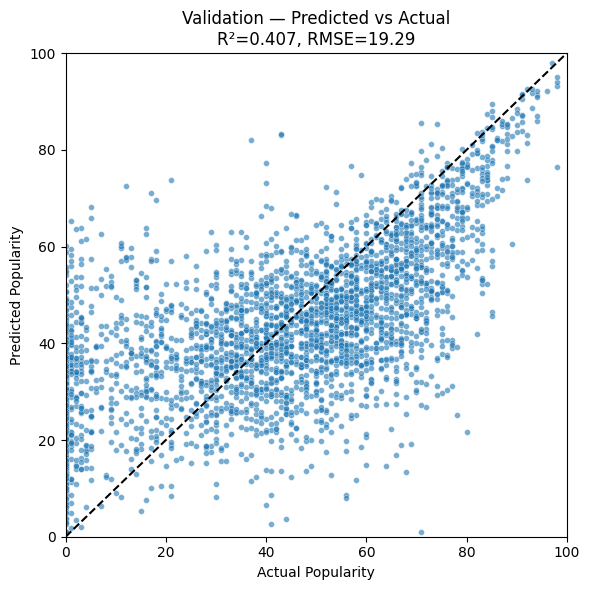

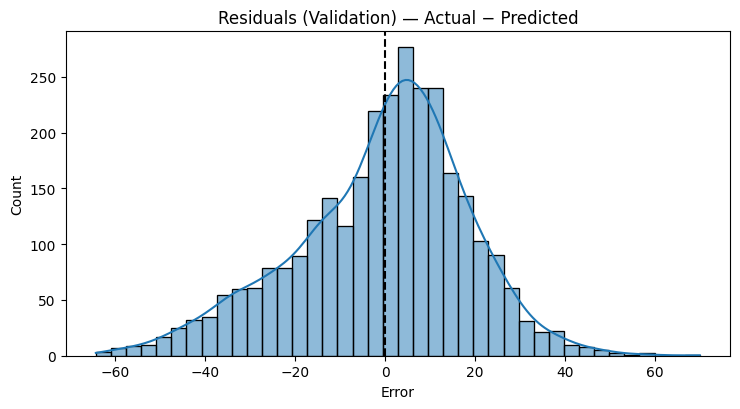

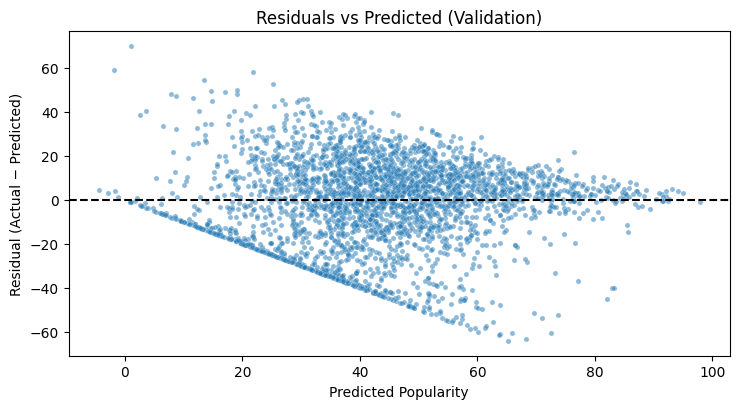

,Val_MAE_by_genre
genre,
edm,13.438436
latin,14.430207
rb,15.176906
rap,15.202621
rock,15.234550
pop,16.581321


💾 Saved → stage7_val_mae_by_genre.csv
💾 Saved → stage7_model_based_importance.csv


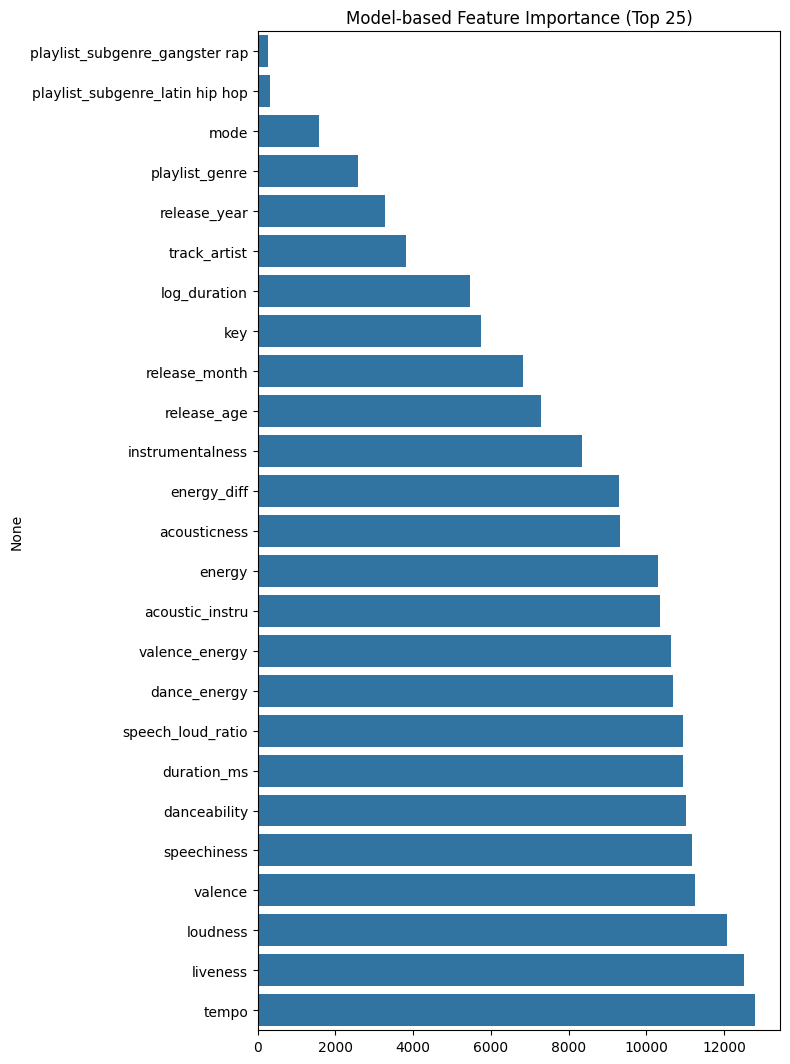

💾 Saved → stage7_permutation_importance_validation.csv


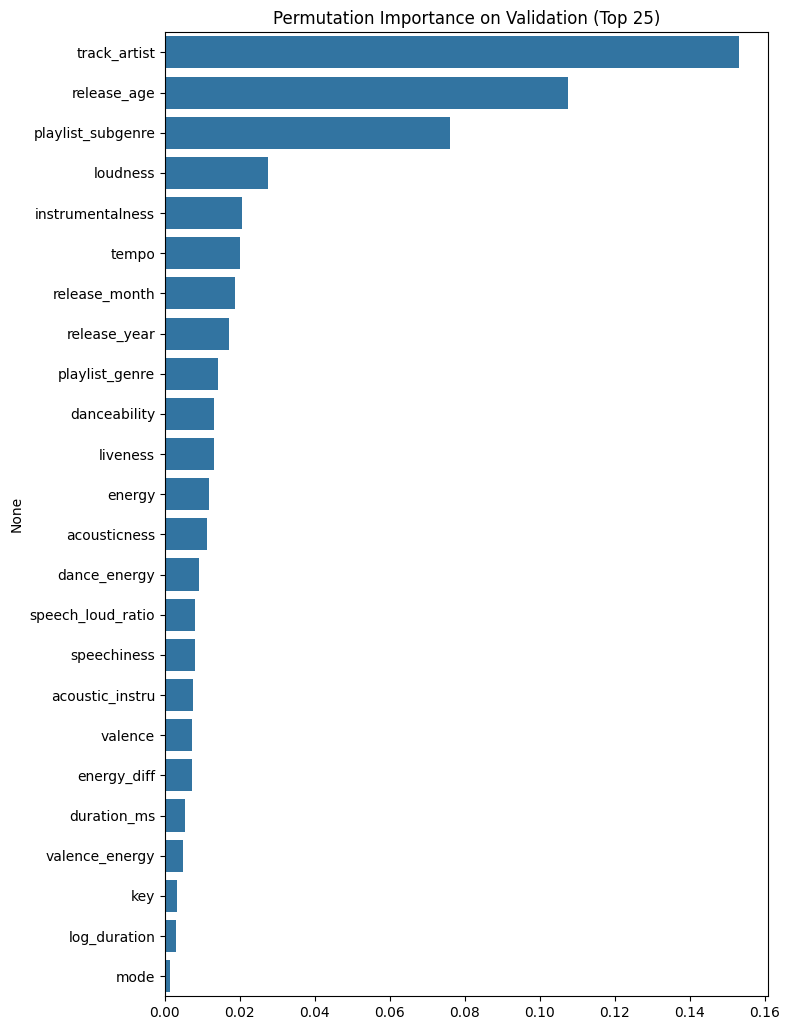


✅ Stage 7 complete — metrics, plots, and CSVs saved.


In [13]:
# ===============================
# Loads best_pipe_stage6.pkl and evaluates on a clean Val/Test split
# ===============================

# Re-declare TEPipe exactly as in Stage 6
class TEPipe(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, smoothing=0.2, min_samples_leaf=20, **kwargs):
        self.cols = cols
        self.smoothing = smoothing
        self.min_samples_leaf = min_samples_leaf
        self.kwargs = kwargs
        self._encoder = None

    def fit(self, X, y=None):
        if not self.cols:
            return self
        self._encoder = ce.TargetEncoder(
            cols=self.cols,
            smoothing=self.smoothing,
            min_samples_leaf=self.min_samples_leaf,
            **self.kwargs
        )
        self._encoder.fit(X[self.cols], y)
        return self

    def transform(self, X):
        if not self.cols:
            return X
        Xt = X.copy()
        te_part = self._encoder.transform(X[self.cols])
        te_part.columns = self.cols  # keep names stable
        Xt[self.cols] = te_part
        return Xt

# Data & feature set
target = "track_popularity"
y = df[target].astype(float)

# Prefer your shortlist if saved in Stage 5; otherwise use a safe fallback
if os.path.exists("stage5_shortlist_features.csv"):
    feat_cols = pd.read_csv("stage5_shortlist_features.csv")["feature"].tolist()
else:
    feat_cols = [
        "danceability","energy","loudness","acousticness","instrumentalness","liveness",
        "speechiness","valence","tempo","duration_ms",
        "dance_energy","valence_energy","acoustic_instru","energy_diff","speech_loud_ratio",
        "log_duration","release_age",
        "playlist_genre","playlist_subgenre","release_year","release_month",
        "track_artist"  # high-card; handled via TE inside the saved pipeline
    ]

feat_cols = [c for c in feat_cols if c in df.columns]
X = df.loc[:, feat_cols].copy()

print(f"Features used: {len(feat_cols)} | Rows: {len(df)}")

# Split: Train / Validation / Test = 80% / 10% / 10%
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f"Train: {len(X_train_full)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Load the saved Stage-6 pipeline
if not os.path.exists("best_pipe_stage6.pkl"):
    raise FileNotFoundError(
        "❌ 'best_pipe_stage6.pkl' not found. Go back to Stage 6 and save your best pipeline:\n"
        "    joblib.dump(best_pipe, 'best_pipe_stage6.pkl')"
    )

best_pipe = joblib.load("best_pipe_stage6.pkl")
print("✅ Loaded pipeline: best_pipe_stage6.pkl")

# Ensure Stage-7 uses EXACT columns the saved pipeline expects

def columns_expected_by_pipeline(pipe):
    req = set()
    # 1) TE step (target encoder) expects these raw categorical columns:
    if "te" in pipe.named_steps and hasattr(pipe.named_steps["te"], "cols") and pipe.named_steps["te"].cols:
        req.update(pipe.named_steps["te"].cols)

    # 2) ColumnTransformer inside "prep" has the exact column names it was fit with
    prep = pipe.named_steps.get("prep", None)
    if prep is not None and hasattr(prep, "transformers_"):
        for name, trans, cols in prep.transformers_:
            if cols is None or cols == "drop":
                continue
            if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
                req.update(list(cols))
            # (rarely cols can be a slice/callable; not typical in your notebook)
    return list(req)

expected_cols = columns_expected_by_pipeline(best_pipe)
missing = [c for c in expected_cols if c not in df.columns]

if missing:
    raise ValueError(
        "❌ Your saved pipeline was trained to expect these columns, "
        f"but they are missing in df: {missing}\n"
        "Tip: if you intentionally removed them in Stage 7, either keep them in X, "
        "or resave a new Stage-6 pipeline trained without those columns."
    )

# Rebuild X with the exact expected columns (order doesn’t have to match)
X = df.loc[:, expected_cols].copy()

# Now continue with your split/eval below
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)


# Fit ONLY on TRAIN, then evaluate on VAL and TEST (no leakage)
best_pipe.fit(X_train_full, y_train_full)

# Metrics helpers
def eval_block(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:>10} → R²: {r2:.3f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")
    return {"Dataset": name, "R2": r2, "RMSE": rmse, "MAE": mae}

# Evaluate
y_val_pred  = best_pipe.predict(X_val)
y_test_pred = best_pipe.predict(X_test)

print("\n📊 Performance")
rows = []
rows.append(eval_block("Validation", y_val, y_val_pred))
rows.append(eval_block("Test",       y_test, y_test_pred))

eval_df = pd.DataFrame(rows)
display(eval_df)
eval_df.to_csv("stage7_model_evaluation.csv", index=False)
print("💾 Saved → stage7_model_evaluation.csv")

# Diagnostic plots (Validation)
# a) Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_val_pred, s=18, alpha=0.6)
lims = [0, 100]; plt.plot(lims, lims, "--", color="black"); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual Popularity"); plt.ylabel("Predicted Popularity")
plt.title(f"Validation — Predicted vs Actual\nR²={r2_score(y_val,y_val_pred):.3f}, RMSE={np.sqrt(mean_squared_error(y_val,y_val_pred)):.2f}")
plt.tight_layout(); plt.savefig("stage7_val_pred_vs_actual.png", dpi=180); plt.show()

# b) Residuals histogram
residuals = y_val - y_val_pred
plt.figure(figsize=(7.5,4.2))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color="black", linestyle="--")
plt.title("Residuals (Validation) — Actual − Predicted")
plt.xlabel("Error")
plt.tight_layout(); plt.savefig("stage7_val_residual_hist.png", dpi=180); plt.show()

# c) Residuals vs Predicted (heteroscedasticity check)
plt.figure(figsize=(7.5,4.2))
sns.scatterplot(x=y_val_pred, y=residuals, s=14, alpha=0.5)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals vs Predicted (Validation)")
plt.xlabel("Predicted Popularity"); plt.ylabel("Residual (Actual − Predicted)")
plt.tight_layout(); plt.savefig("stage7_val_residual_vs_pred.png", dpi=180); plt.show()

# Subgroup error analysis
if "playlist_genre" in X_val.columns:
    tmp = pd.DataFrame({"genre": X_val["playlist_genre"], "abs_err": np.abs(y_val - y_val_pred)})
    genre_mae = tmp.groupby("genre")["abs_err"].mean().sort_values()
    display(genre_mae.to_frame("Val_MAE_by_genre"))
    genre_mae.to_csv("stage7_val_mae_by_genre.csv")
    print("💾 Saved → stage7_val_mae_by_genre.csv")

# Feature importance
# Model-based importance (if the inner model exposes it)
def get_transformed_feature_names(pipe, X_sample: pd.DataFrame):
    X_tmp = X_sample.copy()
    # If your pipeline contains "te" and "prep", expand names appropriately
    if "te" in pipe.named_steps:
        X_tmp = pipe.named_steps["te"].transform(X_tmp)
    ct = pipe.named_steps.get("prep", None)
    if ct is None:
        return X_tmp.columns.to_numpy()
    try:
        return ct.get_feature_names_out(X_tmp.columns)
    except TypeError:
        return ct.get_feature_names_out()

feat_names = get_transformed_feature_names(best_pipe, X_val.iloc[:5])

model = best_pipe.named_steps.get("model", None)
if model is not None:
    model_based = None
    if hasattr(model, "feature_importances_"):
        vals = np.asarray(model.feature_importances_).ravel()
        model_based = pd.Series(vals, index=feat_names, name="model_importance")
    elif hasattr(model, "coef_"):
        vals = np.asarray(model.coef_).ravel()
        model_based = pd.Series(np.abs(vals), index=feat_names, name="model_coef_abs")

    if model_based is not None:
        model_based = model_based.groupby(level=0).sum()  # collapse dup names if any
        model_based.sort_values(ascending=False).head(25).to_csv("stage7_model_based_importance_top25.csv")
        model_based.to_csv("stage7_model_based_importance.csv")
        print("💾 Saved → stage7_model_based_importance.csv")

        top = model_based.sort_values().tail(25)
        plt.figure(figsize=(8, 0.35*len(top)+2))
        sns.barplot(x=top.values, y=top.index, orient="h")
        plt.title("Model-based Feature Importance (Top 25)")
        plt.tight_layout(); plt.savefig("stage7_model_based_importance_top25.png", dpi=180); plt.show()

# Permutation importance on Validation (model-agnostic)
perm = permutation_importance(
    best_pipe, X_val, y_val, n_repeats=10, random_state=42, scoring="r2", n_jobs=-1
)
perm_series = pd.Series(perm.importances_mean, index=X_val.columns, name="perm_importance_r2_drop")
perm_series = perm_series.sort_values(ascending=False)
perm_series.to_csv("stage7_permutation_importance_validation.csv")
print("💾 Saved → stage7_permutation_importance_validation.csv")

plt.figure(figsize=(8, 0.35*min(25, len(perm_series))+2))
sns.barplot(x=perm_series.head(25).values, y=perm_series.head(25).index, orient="h")
plt.title("Permutation Importance on Validation (Top 25)")
plt.tight_layout(); plt.savefig("stage7_perm_importance_top25.png", dpi=180); plt.show()

print("\n✅ Stage 7 complete — metrics, plots, and CSVs saved.")